In [171]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import Preprocessing
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [172]:
TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [173]:
data, all_gdps, all_gts = load_data()

In [174]:
search_terms = [col for col in all_gts.columns if col.endswith('_average')]

processed_gts = all_gts.copy() # Monthly Google Trends
processed_gts['date'] = pd.to_datetime(processed_gts['date'])
processed_gts[search_terms] = np.log(processed_gts[search_terms] + 1)

# for nb_quarters in range(1, 3 * 3):
#     diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_quarters * 3)).add_suffix(f'_{nb_quarters}q_diff')
#     processed_gts = pd.concat([processed_gts, diff], axis=1)

for nb_years in range(1, 3):
    diff = (processed_gts[search_terms] - processed_gts.groupby("country")[search_terms].diff(nb_years * 12)).add_suffix(f'_{nb_years}y_diff')
    processed_gts = pd.concat([processed_gts, diff], axis=1)

processed_gts.drop(columns=search_terms, inplace=True)


In [175]:
print(f"Data shape: {data.shape}")

data['date'] = pd.to_datetime(data['date'])
processed_gts = processed_gts.dropna()
data_merged = data.merge(processed_gts, left_on=["country", "date"], right_on=["country", "date"], how="left")
data_merged['date'] = pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m-%d')

print(f"Data merged shape: {data_merged.shape}")

Data shape: (550, 97)
Data merged shape: (550, 285)


In [176]:
data_dt = data_merged.copy()
data_dt['date'] = pd.to_datetime(data_dt['date'])
splitting_date = data_dt['date'].quantile(TRAIN_PROPORTION)


In [177]:
preprocessor = Preprocessing(data=data_merged, epsilon=EPS, mode=MODE, past_GDP_lags=PAST_GDPS, diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)
X_train, y_train, X_valid, y_valid = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, shuffle=False, splitting_date=splitting_date)

X_train[preprocessor.country_train == "Switzerland"].head()



X_train shape : (438, 292)
X_valid shape : (60, 292)
y_train shape : (438,)
y_valid shape : (60,)


,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,Credit_average,...,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States,month_3,month_6,month_9,month_12
4,0.035926,-1.589690,-1.889848,1.205852,-1.331198,0.707219,-0.610806,1.417080,-1.077500,0.811169,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0
10,-0.017415,-1.519000,-1.889848,1.105522,-1.514042,-1.083470,-0.610806,0.652095,-1.343835,1.034876,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,1.0,0.0,0.0
16,0.462658,-1.306930,-1.889848,1.138965,-1.392146,-0.864760,-0.610806,0.860727,-0.988722,0.721686,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,1.0,0.0
20,-1.297609,-1.589690,-1.889848,1.038635,-1.574990,-1.138147,-0.610806,0.721639,-1.432613,1.079618,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,0.0,0.0,0.0,1.0
28,-0.017415,-1.236239,-1.889848,1.306181,-1.453094,0.898590,-0.610806,1.208448,-1.343835,1.392808,...,-0.413198,-0.374572,-0.413198,2.414624,-0.413198,-0.413198,1.0,0.0,0.0,0.0


In [178]:
# Print all columns that contain Research_and_development
search_term = "Research_and_development"
search_cols = [col for col in X_train.columns if search_term in col]
other_cols = []
X_train[preprocessor.country_train == "Switzerland"][search_cols + other_cols].head()

,Research_and_development_average,Research_and_development_average_1y_diff,Research_and_development_average_2y_diff
4,-1.589690,-0.291910,-6.392120
10,-1.519000,-7.792997,-6.392120
16,-1.306930,-7.792997,-6.392120
20,-1.589690,-0.722410,-0.118996
28,-1.236239,-1.714881,-0.271314


Explained variance ratio: 0.9956449529909497


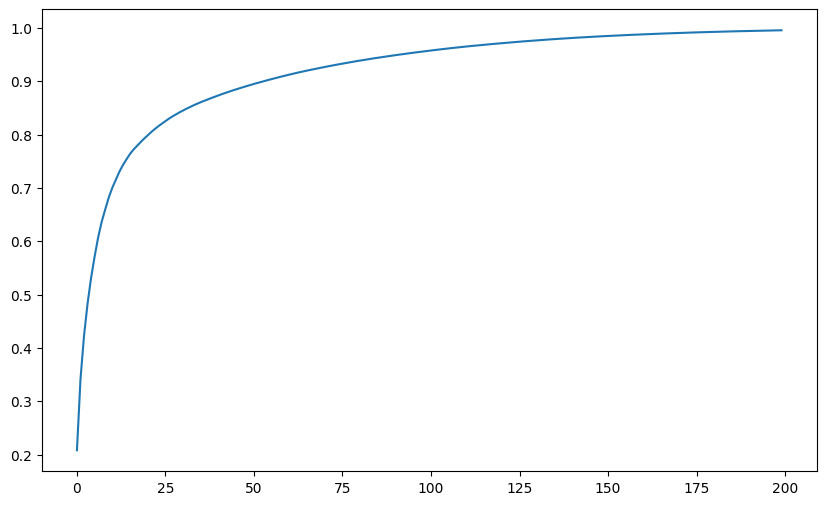

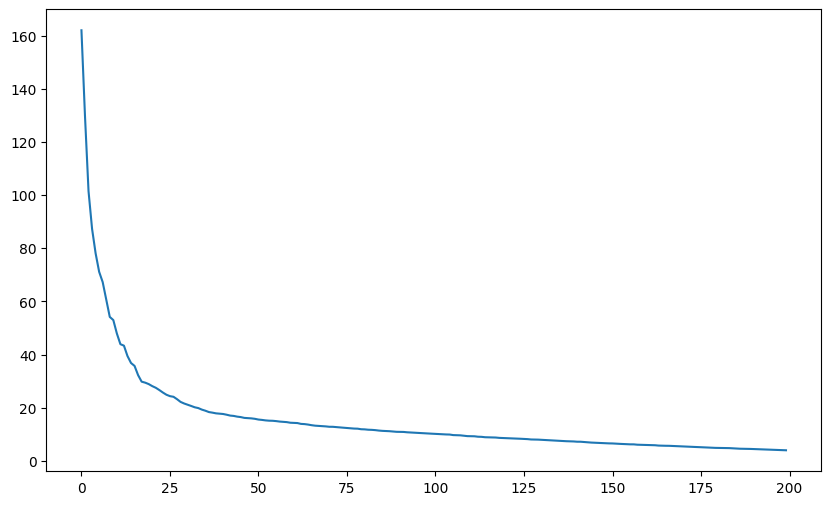

In [179]:
# Apply PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

pca = PCA(200)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()}")
plot.figure(figsize=(10, 6))
plot.plot(np.cumsum(pca.explained_variance_ratio_))

# Plot singular values
plot.figure(figsize=(10, 6))
plot.plot(pca.singular_values_)
plot.show()

In [180]:
# x_train = X_train.values
# x_valid = X_valid.values
x_train = X_train_pca
x_valid = X_valid_pca
y_train = y_train.values
y_valid = y_valid.values
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

## Simple Prediction Model

### We start with a simple regression model

In [181]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [182]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    
    for t in tqdm(range(num_epochs)):
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)
    loss = loss_fn(y_pred, y_valid_t)
    print(f"Validation loss: {loss.item()}")
    
    return model, training_loss, validation_loss

In [183]:
model, training_loss, validation_loss = train_nn(x_train, y_train, x_valid, y_valid, num_epochs=50, learning_rate=1e-3, weight_decay=5e-2)

  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7254398465156555


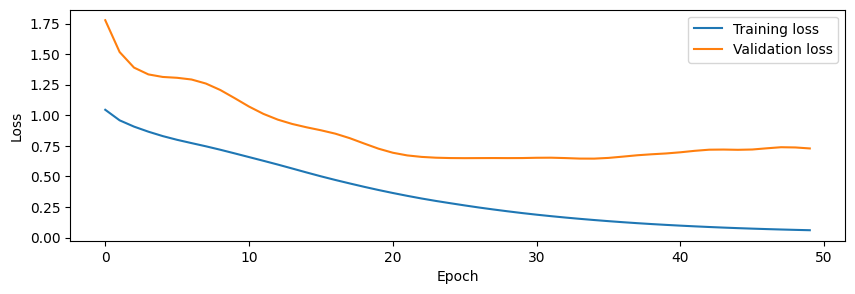

0.6455301642417908

In [184]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

lowest_loss = min(validation_loss)
lowest_loss


In [185]:
# Make bootrapping
n_bootstrap = 250
n = len(x_train)
n_features = x_train.shape[1]

n_countries = len(np.unique(country_train))

bootstrap_size = np.ceil(100 / n_countries).astype(int)

bootstrap_models = []
mse_bootstrap = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    # Make a bootstrap sample of size bootstrap_size
    indices_per_country = [np.where(country_train == c)[0] for c in np.unique(country_train)]
    bootstrap_idx = np.concatenate([np.random.choice(indices, size=bootstrap_size, replace=True) for indices in indices_per_country])
    x_train_bootstrap = x_train[bootstrap_idx]
    y_train_bootstrap = y_train[bootstrap_idx]

    model_bootstrap, _, _ = train_nn(x_train_bootstrap, y_train_bootstrap, x_valid, y_valid, num_epochs=50, learning_rate=1e-3, weight_decay=5e-2)
    y_pred = model_bootstrap(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
    mse = mean_squared_error(y_valid, y_pred)

    bootstrap_models.append(model_bootstrap)
    mse_bootstrap[i] = mse

# Aggregate the predictions
y_pred = np.zeros((x_valid.shape[0], n_bootstrap))
for i in range(n_bootstrap):
    y_pred[:, i] = bootstrap_models[i](torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

y_pred_mean = np.mean(y_pred, axis=1)
y_pred_std = np.std(y_pred, axis=1)
y_pred_median = np.median(y_pred, axis=1)

  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0373104810714722


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1963859796524048


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9178134202957153


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2387112379074097


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8486223220825195


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3131780624389648


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.552259087562561


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2146704196929932


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.626070499420166


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0283292531967163


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1981624364852905


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6918792724609375


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3837056159973145


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.331904649734497


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0855761766433716


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7880576252937317


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6103124618530273


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9333988428115845


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4020286798477173


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2111982107162476


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8313778638839722


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1516624689102173


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.970008909702301


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2389283180236816


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.287285327911377


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3399958610534668


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7326989769935608


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0777524709701538


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4619337320327759


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.6121695041656494


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9601977467536926


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7759004235267639


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1008219718933105


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0062483549118042


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4118328094482422


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2491651773452759


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.8960686922073364


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.7665674686431885


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4272067546844482


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4585822820663452


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8351733088493347


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.434760570526123


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0964630842208862


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.346809983253479


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9418109059333801


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2294611930847168


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2363615036010742


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2518572807312012


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.312063455581665


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.041774034500122


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.10744309425354


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.326463222503662


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.8995134830474854


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1994177103042603


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9032180905342102


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2547649145126343


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0492924451828003


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.978022575378418


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1798293590545654


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.6615407466888428


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0047740936279297


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1115293502807617


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.8207241296768188


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.064927339553833


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.281010389328003


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2791484594345093


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.150220274925232


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.972314476966858


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.408528208732605


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9167799353599548


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3190011978149414


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8010636568069458


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.351717233657837


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.246659755706787


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.0957963466644287


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.9209399223327637


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2383464574813843


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.4615156650543213


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0409876108169556


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0273337364196777


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4322164058685303


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2159333229064941


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.151105284690857


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.99778151512146


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0679748058319092


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3126453161239624


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2178195714950562


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2243996858596802


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.1100869178771973


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9445986151695251


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1975513696670532


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2079633474349976


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8957910537719727


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.641810655593872


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0658358335494995


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6936086416244507


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.5697500705718994


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.042041301727295


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0821528434753418


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2436689138412476


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6171019077301025


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9256957173347473


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3221580982208252


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8212137222290039


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.1688075065612793


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3977339267730713


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1578234434127808


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3204301595687866


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.416368246078491


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.48329758644104


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1903899908065796


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.329194188117981


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0270780324935913


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8431824445724487


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.168016195297241


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.478780746459961


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.444110631942749


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1777936220169067


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.25726056098938


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8169890642166138


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.5499606132507324


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.007265329360962


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9736724495887756


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.054891347885132


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3467899560928345


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.345970869064331


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4887747764587402


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1369657516479492


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9853812456130981


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4233906269073486


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9300406575202942


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7779940962791443


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.927720308303833


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4595708847045898


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7010971903800964


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4906343221664429


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.2009897232055664


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.505690336227417


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8549467921257019


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.5548992156982422


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4039268493652344


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0316033363342285


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.315617322921753


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.7496265172958374


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.5610696077346802


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.117682933807373


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.729847252368927


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2833226919174194


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9316573739051819


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.306164026260376


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1745450496673584


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8527223467826843


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0817729234695435


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9878177046775818


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.7059199810028076


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2043845653533936


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0675615072250366


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.025895357131958


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.969550609588623


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8930367231369019


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 2.643028736114502


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2567960023880005


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9717763066291809


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1451648473739624


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1819347143173218


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2388185262680054


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0292593240737915


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1518983840942383


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9140977263450623


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3526787757873535


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9513921737670898


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7958864569664001


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7901613116264343


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8246432542800903


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2185338735580444


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3436195850372314


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8283641338348389


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.8422240018844604


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.7277153730392456


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6799894571304321


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6805003881454468


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0398977994918823


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4042271375656128


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.5942790508270264


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9905239343643188


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9251251220703125


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9893304705619812


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1751970052719116


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2842950820922852


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1265588998794556


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7356006503105164


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1848993301391602


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.701479434967041


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8841521143913269


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1489198207855225


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0062682628631592


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2596232891082764


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0422536134719849


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3187366724014282


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8217290639877319


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2241599559783936


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.165310025215149


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3452212810516357


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7839708924293518


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0979983806610107


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2492048740386963


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9541828632354736


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4235087633132935


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6433923244476318


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2606825828552246


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.8396340608596802


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8886435627937317


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0453394651412964


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1120290756225586


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.6593185663223267


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0173602104187012


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.6185646057128906


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4007525444030762


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.275214433670044


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8306887149810791


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0519939661026


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.439728021621704


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8278417587280273


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1246421337127686


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.2211421728134155


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9208269119262695


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.427973985671997


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1997824907302856


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.125947117805481


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4534295797348022


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.3353149890899658


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.8641828298568726


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4633690118789673


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.045414924621582


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.5544445514678955


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.118243932723999


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1229218244552612


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0948669910430908


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.7709977626800537


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0533108711242676


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0947601795196533


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 0.9097067713737488


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1470131874084473


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.1333236694335938


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0136103630065918


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0313416719436646


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.7240759134292603


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.173742651939392


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.0144875049591064


  0%|          | 0/50 [00:00<?, ?it/s]

Validation loss: 1.4501463174819946


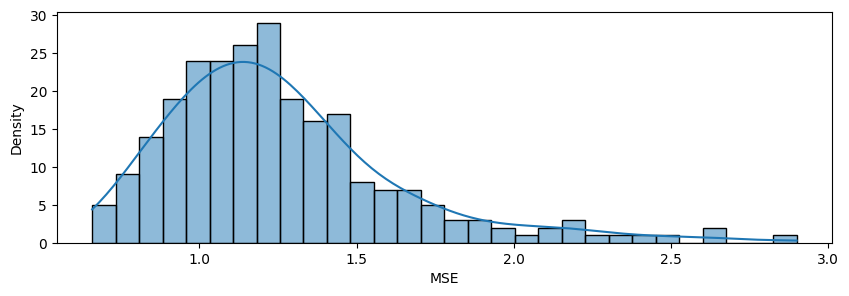

In [186]:
plt.figure(figsize=(10, 3))
sns.histplot(mse_bootstrap, bins=30, kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.show()

In [187]:
# Plot the predictions per country, per date
def plot_by_country(selected_country):
    plt.figure(figsize=(15, 5))
    plt.plot(y_valid[country_valid == selected_country], label="True")
    plt.plot(y_pred_mean[country_valid == selected_country], label="Predicted")
    plt.plot(y_pred_median[country_valid == selected_country], label="Predicted (median)")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + y_pred_std[country_valid == selected_country], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(country_valid))

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

<function __main__.plot_by_country(selected_country)>

In [188]:
# Get the predictions
x_valid = torch.tensor(x_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [189]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [190]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [191]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('United States', 'Canada', 'Korea', 'United Ki…

In [192]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[(predictions_melted["country"] == selected_country) & (predictions_melted["Set"] == "Validation")]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('United States', 'Canada', 'Korea', 'United Ki…